In [128]:
# # Install PyWake if needed
# try:
#     import py_wake
# except ModuleNotFoundError:
#     !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Instalação
**(topfarm é recomendado para <3.12)**

- conda create --name ENVNAME python=3.11 
- conda activate ENVNAME
- pip install py_wake
- pip install topfarm
- pip install pyproj

In [129]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import concurrent.futures
import matplotlib.pyplot as plt
from py_wake.flow_map import HorizontalGrid, YZGrid, Points, XYGrid, XZGrid
from pyproj import Proj, Transformer
import py_wake as pw
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd


In [130]:
serie_historica = "/media/wendell/Windows Backup/Eolico_serie_temporal_alturas/100m/2017_raw_100m_filled.nc"
densidade_regiao = "/media/wendell/Windows Backup/Eolico_serie_temporal_alturas/100m/densidade_100m_netcdf.nc"

In [131]:
dataset = xr.open_dataset(serie_historica)
den = xr.open_dataset(densidade_regiao)

In [132]:
dataset

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 8760, lon: 168, lat: 135)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon      (lon) float32 672B -38.92 -38.89 -38.86 ... -34.44 -34.41 -34.38
  * lat      (lat) float32 540B -7.415 -7.388 -7.361 ... -3.85 -3.823 -3.796
Data variables:
    wspd     (time, lat, lon) float64 2GB ...
    wdir     (time, lat, lon) float64 2GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    history:      Thu Mar 03 14:24:21 2022: cdo mergetime 2017-01_100m 2017-0...
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [133]:
largura =dataset['lat'].values[1] - dataset['lat'].values[0]

In [134]:
# Função para determinar a UTM zone based na longitude
def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1

# Function to convert degrees to UTM coordinates using vectorized operations
def convert_to_utm_vectorized(lat_array, lon_array):
    utm_zones = np.vectorize(get_utm_zone)(lon_array)
    utm_x = np.zeros_like(lat_array)
    utm_y = np.zeros_like(lat_array)
    
    for zone in np.unique(utm_zones):
        mask = utm_zones == zone
        hemisphere = 'north' if np.mean(lat_array[mask]) >= 0 else 'south'
        proj_wgs84 = Proj('epsg:4326')  # WGS84
        proj_utm = Proj(proj='utm', zone=zone, datum='WGS84', south=hemisphere=='south')
        transformer = Transformer.from_proj(proj_wgs84, proj_utm)
        utm_x[mask], utm_y[mask] = transformer.transform(lat_array[mask], lon_array[mask])
    
    return utm_x, utm_y, hemisphere

In [135]:
#Função para definir os setores relacionados com a direção dos ventos
def custom_sector(wd):
    """
    Maps wind directions to sectors, handling the wrap-around between 345° and 15°.
    """
    sectors = np.zeros_like(wd)  # Initialize an array for sector values
    sectors[(wd >= 345) | (wd < 15)] = 0   # Sector 0 for 345-15 degrees
    sectors[(wd >= 15) & (wd < 345)] = (wd[(wd >= 15) & (wd < 345)] - 15) // 30 + 1  # Sectors 1-11
    return sectors

# def custom_sector(wd):
#     """
#     Maps wind directions to 12 sectors, each spanning 30 degrees starting from 0°.
#     """
#     sectors = np.zeros_like(wd)  # Initialize an array for sector values
#     sectors = (wd // 30) % 12  # Divide wind direction by 30 and take the modulo 12
#     return sectors

Até o momento só consegui gerar os parametros de Weibull para usar em um pixel e esse como um apenas um parque "UniformWeibullSite" -  Site with uniform sector-dependent Weibull distributed wind speed.

Waspgrid pode ser uma alternativa mas esse nessecita de um arquivo .grd  exportado do WAsp

In [136]:
#Selecionar os dados usando as coordenadas para selecionar a linha
dataset = dataset.sel(lat=slice(-7.415, -7.388), lon=slice(-38.92, -38.89))

#Usando Sel consegue passar o "Index = Coordenada para xarray" para selecionar o dado
den = den.sel(lat=slice(-7.415, -7.388), lon=slice(-38.92, -38.89))

#Extrair os valores de cada dado conservando as coordenadads e o timestamp
wind_speed = dataset['wspd'] # 3D DataArray [time, lat, lon]
wind_direction = dataset['wdir']  # Same shape as wind_speed
air_density = den['Band1']  # 2D DataArray [lat, lon]
date_time = dataset['time']
lati = dataset['lat']
long = dataset['lon']

In [137]:
# Function to fit Weibull distribution and return parameters
def fit_weibull(data):
    c, loc, scale = weibull_min.fit(data, floc=0)
    return scale, c  # Weibull_A, Weibull_k

# Function to fit Weibull distribution for each sector over all time slices
def fit_weibull_sectors(wind_speed_data, sector_data):
    results = []
    for sector in range(12):
        sector_data_values = wind_speed_data.where(sector_data == sector, drop=True).values.flatten()
        sector_data_values = sector_data_values[~np.isnan(sector_data_values)]  # Remove NaNs
        if len(sector_data_values) > 0:
            scale, c = fit_weibull(sector_data_values)
        else:
            scale, c = np.nan, np.nan
        results.append((scale, c))
    return results


In [138]:
# Calcula setor para as direções do vento
sectors = custom_sector(wind_direction.values)
sectors = xr.DataArray(sectors, coords=wind_direction.coords, dims=wind_direction.dims)  # Converte para DataArray

# Calcula a distribuição de Weibull para cada setor
Weibull_A_k = fit_weibull_sectors(wind_speed, sectors)

In [139]:
Weibull_A_k

[(np.float64(5.047496174615445), np.float64(3.0409498894174165)),
 (np.float64(4.951255989657237), np.float64(2.063581107620001)),
 (np.float64(4.811635035381411), np.float64(2.0994595860208074)),
 (np.float64(4.9750994195899505), np.float64(2.2229708826304644)),
 (np.float64(5.288234011649904), np.float64(2.2370205216244035)),
 (np.float64(7.667684977335193), np.float64(3.024665503191133)),
 (np.float64(6.897832893386719), np.float64(3.435526678796057)),
 (np.float64(3.762528764616948), np.float64(1.316426110394726)),
 (np.float64(3.0713585394267984), np.float64(1.9412721759214928)),
 (np.float64(2.5581200671179354), np.float64(1.8856911658228892)),
 (np.float64(3.6856858509132255), np.float64(1.9263019946876099)),
 (np.float64(4.167666547462828), np.float64(2.4902322070567617))]

In [140]:
# Separa o A do K de Weibull
Weibull_A = [result[0] for result in Weibull_A_k]
Weibull_k = [result[1] for result in Weibull_A_k]


In [141]:
print(sectors)
print(wind_speed)

<xarray.DataArray (time: 8760, lat: 1, lon: 1)> Size: 70kB
5.0 5.0 5.0 6.0 6.0 6.0 6.0 5.0 5.0 5.0 ... 3.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 3.0
Coordinates:
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon      (lon) float32 4B -38.92
  * lat      (lat) float32 4B -7.415
<xarray.DataArray 'wspd' (time: 8760, lat: 1, lon: 1)> Size: 70kB
[8760 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon      (lon) float32 4B -38.92
  * lat      (lat) float32 4B -7.415


In [142]:
# Cria um novo Dataset combinando wind_speed e sectors
combined_ds = xr.Dataset(
    {
        'wind_speed': wind_speed,
        'sector': sectors
    }
)
combined_ds

<xarray.Dataset> Size: 210kB
Dimensions:     (time: 8760, lon: 1, lat: 1)
Coordinates:
  * time        (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon         (lon) float32 4B -38.92
  * lat         (lat) float32 4B -7.415
Data variables:
    wind_speed  (time, lat, lon) float64 70kB ...
    sector      (time, lat, lon) float64 70kB 5.0 5.0 5.0 6.0 ... 2.0 2.0 3.0

In [143]:
ti = []
sec = np.unique(sectors.values)
for i in sec:
    sector_data = combined_ds.where(sectors == i, drop=True)
    u_sector = sector_data['wind_speed'].mean(dim='time')  # Média do vento no setor i
    std_sector = sector_data['wind_speed'].std(dim='time')
    ti.append(u_sector.data.item()/std_sector.data.item())
    print(f"Setor {i}: {ti[-1]}")


Setor 0.0: 2.7212060123102884
Setor 1.0: 1.952202317637892
Setor 2.0: 1.9772424172704666
Setor 3.0: 2.088775465849997
Setor 4.0: 2.1039914807734337
Setor 5.0: 2.722098727004091
Setor 6.0: 3.109147708327291
Setor 7.0: 1.356784286826237
Setor 8.0: 1.8573824884920185
Setor 9.0: 1.7949743734632673
Setor 10.0: 1.8445919513766003
Setor 11.0: 2.30355461439058


In [144]:
# Calcula a frequencia de cada direção
sector_counts = sectors.to_series().value_counts().sort_index()
total_count = sector_counts.sum()
f = (sector_counts / total_count).to_list()

#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"
wd = np.linspace(0, 360, len(f), endpoint=False)

ds = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', Weibull_A),
        'Weibull_k': ('wd', Weibull_k),
        'TI': ('wd', ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
#        'lat': lati,
#        'lon': long,
    }
)

In [145]:
ds

<xarray.Dataset> Size: 480B
Dimensions:           (wd: 12)
Coordinates:
  * wd                (wd) float64 96B 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    Sector_frequency  (wd) float64 96B 0.0274 0.05719 ... 0.01324 0.02306
    Weibull_A         (wd) float64 96B 5.047 4.951 4.812 ... 2.558 3.686 4.168
    Weibull_k         (wd) float64 96B 3.041 2.064 2.099 ... 1.886 1.926 2.49
    TI                (wd) float64 96B 2.721 1.952 1.977 ... 1.795 1.845 2.304

UniformWeibullSite: Site with uniform sector-dependent Weibull distributed wind speed.

WaspGridSite: Site with gridded non-uniform inflow based on *.grd files exported from WAsP.

XRSite: The flexible general base class behind all Sites.

In [146]:
# Create an XRSite object: cria o dataset para altura de referencia da maquina utilizando lei de potencia
site = XRSite(ds=ds, shear=PowerShear(h_ref=100))


Se precisar salvar varios arquivos NetCDF para salvar as distribuições de Weibull para usar depois e calcular o parque de forma separada

- Salvar o site em um netCDF
site_ds = site.ds
site_ds.to_netcdf('teste_site.nc')

- Carregar o XRSite data do NetCDF
loaded_site_ds = xr.open_dataset('teste_site.nc')

- Create a new XRSite object using the loaded data
loaded_site = XRSite(ds=loaded_site_ds, shear=PowerShear(h_ref=100))

- Verify the loaded data (optional)
print(loaded_site.ds)

In [147]:
# Replace 'your_file.csv' with the path to your CSV file
csv_file_path = '/media/wendell/Windows Backup/Arquivos_wendell/NREL_5MW_126_RWT.csv'

# Read the CSV file into a DataFrame
tb = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(tb.head())

   Wind Speed [m/s]  Power [kW]    Cp [-]  Thrust [kN]    Ct [-]
0               3.0        40.5  0.196406        171.7  2.497990
1               4.0       177.7  0.363555        215.9  1.766833
2               5.0       403.9  0.423084        268.9  1.408360
3               6.0       737.6  0.447126        330.3  1.201348
4               7.0      1187.2  0.453203        398.6  1.065134


In [148]:
############################################################################################
#************Turbina NREL
############################################################################################
vel_turbine = tb['Wind Speed [m/s]']
pot_turbine = tb['Power [kW]']
ct = tb['Ct [-]']

# Define the hub height of the turbine
hub_height = 110  # in meters

wt_NREL = WindTurbine(name='NRel5MW',
                    diameter=150,
                    hub_height=hub_height,
                    powerCtFunction=PowerCtTabular(vel_turbine,pot_turbine,'kW',ct))

In [149]:
############################################################################################
#************Turbina
############################################################################################
vel_turbine = np.arange(0, 23, .5)
pot_turbine = [0,0,0,0,0,0,49, 127, 224, 339, 480, 651, 857, 1099, 1382, 1705, 2067, 2460, 2849, 3174, 3369, 3434, 3449, 3450, 3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450]
ct = np.ones(46)*0.8

# Define the hub height of the turbine
hub_height = 100  # in meters

my_wt = WindTurbine(name='MyWT',
                    diameter=136,
                    hub_height=hub_height,
                    powerCtFunction=PowerCtTabular(vel_turbine,pot_turbine,'kW',ct))

In [150]:
#Importes para conseguir gerar o Wake model
from tqdm.notebook import tqdm
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit, profileit
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.utils.plotting import setup_plot
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

In [151]:
deslocamento = largura/2
x = np.arange((-5.756739 - deslocamento),
               (-5.756739 + deslocamento),
                 (largura/3))
y = np.arange((-36.007004 - deslocamento),
               (-36.007004 + deslocamento),
                 (largura/3))

#x, y = convert_to_utm_vectorized(x, y)

In [152]:
print(-5.756739 - deslocamento)
print(-36.007004 - deslocamento)
print(x, y)

-5.7701936
-36.02046
[-5.77019358 -5.76122379 -5.75225401] [-36.02045822 -36.01148987 -36.00252151]


In [ ]:
def convert_to_utm_vectorized(lon_array, lat_array):
    # Ensure inputs are numpy arrays
    lat_array = np.asarray(lat_array)
    lon_array = np.asarray(lon_array)

    # Vectorized UTM zone
    get_zone_vectorized = np.vectorize(get_utm_zone)
    utm_zones = get_zone_vectorized(lon_array)

    # Prepare outputs
    utm_x = np.zeros_like(lon_array)
    utm_y = np.zeros_like(lat_array)
    hemisphere_array = np.full_like(lat_array, '', dtype=object)

    for zone in np.unique(utm_zones):
        mask = utm_zones == zone
        hemisphere = 'north' if np.mean(lat_array[mask]) >= 0 else 'south'
        proj_wgs84 = Proj('epsg:4326')
        proj_utm = Proj(proj='utm', zone=zone, datum='WGS84', south=(hemisphere == 'south'))
        transformer = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)
        utm_x[mask], utm_y[mask] = transformer.transform(lon_array[mask], lat_array[mask])
        hemisphere_array[mask] = hemisphere

    return utm_x, utm_y, hemisphere_array


In [154]:
x, y, hemisferio = convert_to_utm_vectorized(x, y)
print(x, y, hemisferio)

[250363.29642103 251143.58516762 251924.06187371] [6010231.88194148 6011249.93427972 6012267.90615202] ['south' 'south' 'south']


In [155]:
#Fucção para calcular o efeito esteira associado ao  parque eolico para todas as direções
xr.set_options(display_expand_data=False)


#wf_model = Bastankhah_PorteAgel_2014(site, my_wt, k=0.0324555)

wf_model = PropagateDownwind(site, wt_NREL,
                             wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                             superpositionModel=LinearSum())

#x = [-500., -500., -500.,    0.,    0.,    0.,  500.,  500.,  500.]
#y = [-500.,    0.,  500., -500.,    0.,  500., -500.,    0.,  500.]

#x, y =convert_to_utm_vectorized(np.array([-5.756739]), np.array([-36.007004]))
sim_res = wf_model(x, y,     # arrays com as posições dos aerogeradores
                   h=None,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   wd=None,  # Wind direction, default is all direction, list or value should be passed as argument
                   ws=None,  # Wind speed, default is all speeds, list or values should be passed
                  )

In [156]:
#x,y = convert_to_utm_vectorized(np.array([-7.414711, -7.387802]), np.array([-38.917034, -38.889893]))


In [157]:
sim_res

<xarray.SimulationResult> Size: 879kB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) int64 24B 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.029 4.038 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.721 2.721 ... 2.707 2.707
    Power             (wt, wd, ws) float64 199kB 4.444e+04 1.864e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.477 1.753 ... 0.08373 0.07737
    h                 (wt) float64 24B 110.0 110.0 110.0
    x                 (wt) float64 24B 2.504e+05 2.511e+05 2.519e+05
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 5.047 5.044 5.041 ... 4.96 4.989 5.018
    Weibull_k         (wd) float64 3kB 3.041 3.008 2.976 ... 2.986 3.004 3.023
    Sector_frequency  (wd) float64 3kB 0.0009132 0.0009463 ... 0.0009084
    P                 (wd, ws) float64 66kB 0.000154 0.0002065 ... 0.0 0.0

In [158]:
#Produção de energia eletrica para a turbina zero (wt=0) com o vento na direção
print(sim_res.Power.sel(wt=0))

#Potencia total da turbina 0
total_power = sim_res.Power.sel(wt=2).sum().values/1e6
print(total_power)

#AEP das turbinas de todas as velocidade e direções, aep por padrão considera efeitos de perda"sim_res.aep(with_wake_loss=False).sum().data"
print('Total power: %f GWh'%sim_res.aep().sum().values)


<xarray.DataArray 'Power' (wd: 360, ws: 23)> Size: 66kB
4.444e+04 1.864e+05 4.199e+05 7.634e+05 1.226e+06 ... 5e+06 5e+06 5e+06 5e+06
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    wt       int64 8B 0
    type     int64 8B 0
Attributes:
    Description:  Power [W]
30597.368275652923
Total power: 22.961439 GWh


In [159]:
total_power = sim_res.Power.sel(wt=2, wd=100).sum().values/1e6
print('Total power: %f MW'%total_power)

Total power: 85.305314 MW


In [160]:
sim_res

<xarray.SimulationResult> Size: 879kB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) int64 24B 0 0 0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.029 4.038 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.721 2.721 ... 2.707 2.707
    Power             (wt, wd, ws) float64 199kB 4.444e+04 1.864e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.477 1.753 ... 0.08373 0.07737
    h                 (wt) float64 24B 110.0 110.0 110.0
    x                 (wt) float64 24B 2.504e+05 2.511e+05 2.519e+05
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 5.047 5.044 5.041 ... 4.96 4.989 5.018
    Weibull_k         (wd) float64 3kB 3.041 3.008 2.976 ... 2.986 3.004 3.023
    Sector_frequency  (wd) float64 3kB 0.0009132 0.0009463 ... 0.0009084
    P                 (wd, ws) float64 66kB 0.000154 0.0002065 ... 0.0 0.0

Text(0.5, 1.0, 'Wake map for 150 deg and 10 m/s')

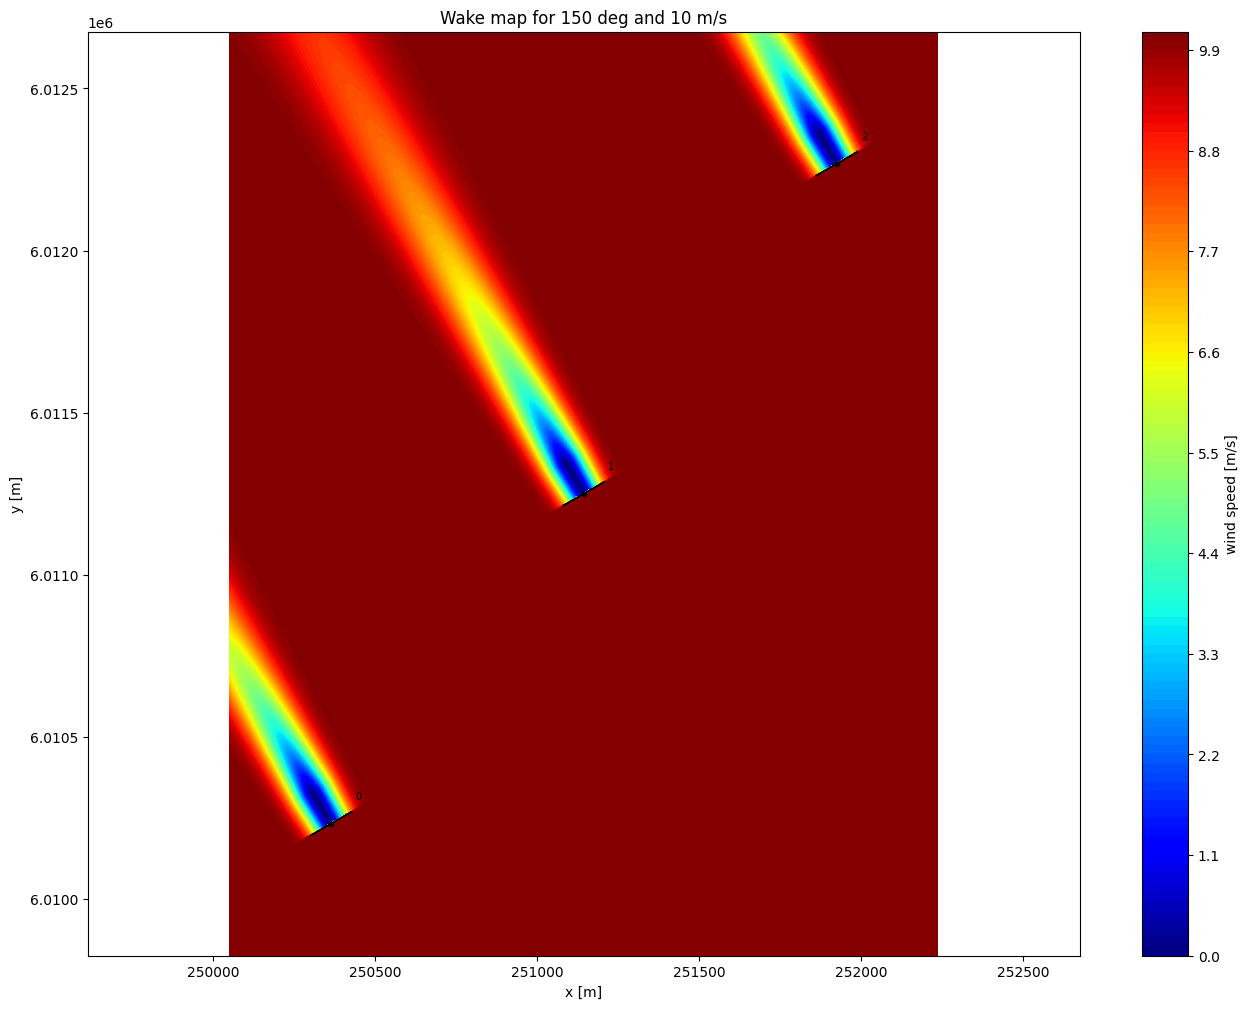

In [161]:

plt.figure(figsize=(16, 12))
teste = wf_model(x, y, type=0, wd=150, ws=10, h=110, n_cpu=16).flow_map().plot_wake_map(cmap='jet')
# flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
#                        cmap='jet', # color map
#                        plot_colorbar=False,
#                        plot_windturbines=False,
#                        ax=None)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {150} deg and {10} m/s')


Text(0, 0.5, 'z [m]')

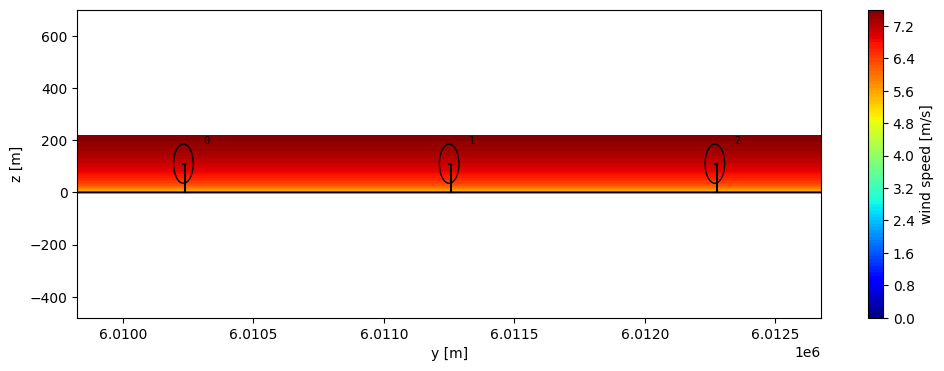

In [162]:
from py_wake import YZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(YZGrid(x=-500, y=None, resolution=1000), wd=150, ws=None).plot_wake_map(cmap='jet')
plt.xlabel('y [m]')
plt.ylabel('z [m]')

Text(0, 0.5, 'z [m]')

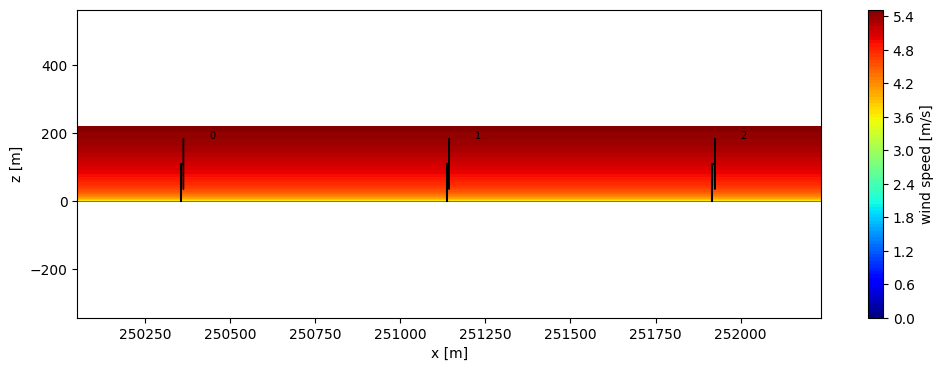

In [163]:
from py_wake import XZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=90, ws=None).plot_wake_map(cmap='jet')
plt.xlabel('x [m]')
plt.ylabel('z [m]')

In [164]:
#Import para simulação da farm com o wake model
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian     #wake model
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site         #wind turbines and site used
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent   #cost model

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySimpleGADriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import NoPlot, XYPlotComp


In [165]:
x

array([250363.29642103, 251143.58516762, 251924.06187371])

In [166]:
n_wt = 9
n_wd = 16


cost_comp = PyWakeAEPCostModelComponent(wf_model, n_wt, wd=wd)

#Gera as direções para simular o posicionamento
wd = np.linspace(0.,360.,n_wd, endpoint=False)

initial_position = {'x': x, 'y': y}

driver = EasyScipyOptimizeDriver(maxiter=300, tol=1e-12) # o metodo utilizado para otimizar
#driver  = EasySimpleGADriver(max_gen=300, pop_size=25, run_parallel=True)

In [167]:
# Import topfarm problem, plotting support, constraint classes and generic cost model component
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

In [168]:
# set up a "boundary" array with arbitrary points for use in the example
boundary = np.array([(-350, -350), (-350, 350), (350, -350), (350, 350)])

contraints_teste = XYBoundaryConstraint(boundary, 'convex_hull') #Metodo para criação do formato do boundary
limites = [SpacingConstraint(200), contraints_teste]


In [169]:
#Criando os parametros para a otimização com o TopFarm
tf_problem = TopFarmProblem(
            initial_position,
            cost_comp = cost_comp,
            constraints=limites,
            driver=driver,
            plot_comp=XYPlotComp())

_, state, _ = tf_problem.optimize()

#print(state) # Posições otimizadas

RuntimeError: 
Collected errors for problem 'problem4':
   <model> <class Group>: The source and target shapes do not match or are ambiguous for the connection 'indeps.x' to 'cost_comp.x'. The source shape is (3,) but the target shape is (9,).
   <model> <class Group>: The source and target shapes do not match or are ambiguous for the connection 'indeps.y' to 'cost_comp.y'. The source shape is (3,) but the target shape is (9,).

Text(0.5, 1.0, 'Wake map for 150 deg and 10 m/s')

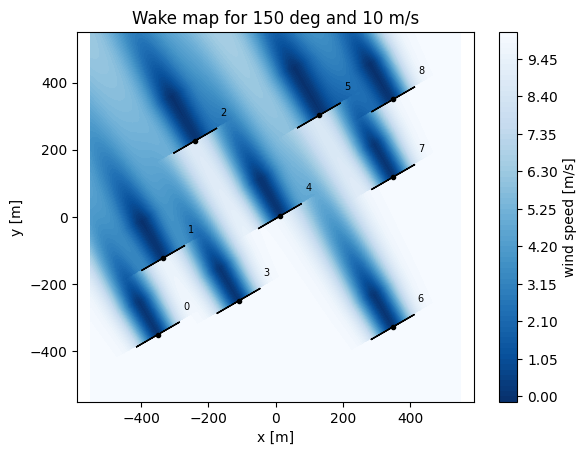

In [ ]:
#Simulação para o plot
wf_model(state['x'], state['y'], type=0, wd=[150], ws=10, h=100, n_cpu=None).flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {150} deg and {10} m/s')

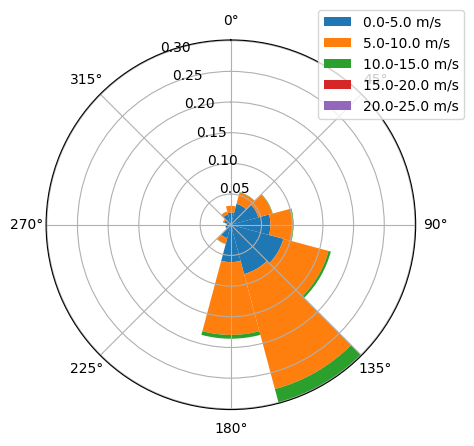

In [ ]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25]) #PLota a rosa dos ventos com a velocidade

In [ ]:
#Import para usar duas funções para otimizar x,y e levar yaw
import warnings
warnings.filterwarnings("ignore")

from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot
from topfarm.easy_drivers import EasyScipyOptimizeDriver


In [ ]:

#choosing the flow cases for the optimization
wsp = np.arange(3, 13, 1)
wdir = np.arange(100, 170, 10)

#getting initial position of turbines
n_wt = len(x)

#setting up yaw angles for each turbine, wind direction and wind speed
i = n_wt
k = wsp.size
l = wdir.size
yaw_zero = np.zeros((i,l,k))  #initial condition of yaw angles


In [ ]:
#criação da função de custo, levando em consideração x,y e yaw dos aerogeradores
def aep_func(x, y, yaw_ilk):
    simres = wf_model(x,y,wd=wdir,ws=wsp,yaw=yaw_ilk, tilt=0)
    aep = simres.aep().sum()
    return aep


In [ ]:
#criação do modelo de custo
cost_comp = CostModelComponent(input_keys=['x','y',('yaw_ilk', np.zeros((i, l, k)))],
                                          n_wt = n_wt,
                                          cost_function = aep_func,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0)]
                                          )


In [ ]:
#limitador da otimização
maxiter=300
tol=1e-8
ec=1e-4

problem = TopFarmProblem(design_vars={'x': x, 'y': y, 'yaw_ilk': (yaw_zero, -30, 30)},  #setting up initial values and lower and upper bounds for yaw angles
                          n_wt=n_wt,
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=NoPlot(),
                          constraints=limites,
                          expected_cost=ec)

_, state,_ = problem.optimize()


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000127 sec).
INFO: checking system...
INFO:     system check complete (0.000005 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000056 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000017 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000059 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000015 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000004 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000055 sec).
INFO: checking system...
INFO:     system check complete (0.000004 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000038 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check com

34.32106182430202


(9, 7, 10)

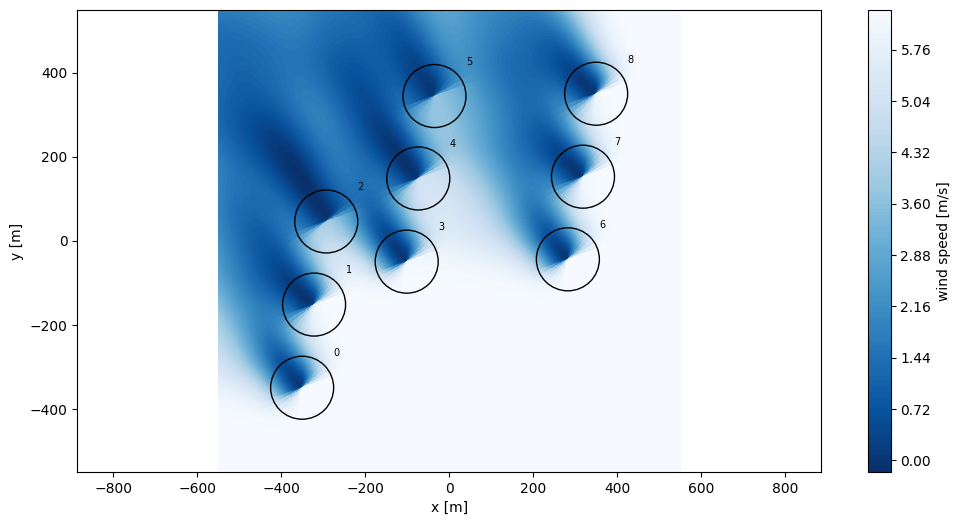

In [ ]:
#PLot levando em consideração a posição e o Yaw dependendo de vento e velocidade
simulationResult = wf_model(state['x'],state['y'],wd=wdir, ws=wsp, yaw=state['yaw_ilk'][:,:,0], tilt=0)
plt.figure(figsize=(12,6))
simulationResult.flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

print(simulationResult.aep().sum().values)
state['yaw_ilk'].shape



In [ ]:
state['yaw_ilk']

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -5.36977459e-05,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -4.30322569e-05,  0.00000000e+00, -3.73147154e-05,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00, -3.85347713e-05,  0.00000000e+00,
         -1.82226534e-05,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00, -5.03362158e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -6.78121938e-06, -1.60805497e-05,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -9.03021670e-06, -1.49665110e-05,
          0.00000000e+00,  2.00197484e-06,  0.000000

In [ ]:
simulationResult.flow_map()

<xarray.FlowMap> Size: 840MB
Dimensions:  (x: 500, y: 500, h: 1, wd: 7, ws: 10)
Coordinates:
  * x        (x) float64 4kB -550.0 -547.8 -545.6 -543.4 ... 545.6 547.8 550.0
  * y        (y) float64 4kB -550.0 -547.8 -545.6 -543.4 ... 545.6 547.8 550.0
  * h        (h) float64 8B 110.0
  * wd       (wd) int64 56B 100 110 120 130 140 150 160
  * ws       (ws) int64 80B 3 4 5 6 7 8 9 10 11 12
Data variables:
    WS_eff   (y, x, h, wd, ws) float64 140MB 3.029 4.038 5.048 ... 11.11 12.11
    TI_eff   (y, x, h, wd, ws) float64 140MB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    WD       (y, x, h, wd, ws) int64 140MB 100 100 100 100 ... 160 160 160 160
    WS       (y, x, h, wd, ws) float64 140MB 3.029 4.038 5.048 ... 11.11 12.11
    TI       (y, x, h, wd, ws) float64 140MB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    P        (y, x, h, wd, ws) float64 140MB 0.00645 0.006961 ... 0.001244

In [ ]:
simulationResult.flow_map().to_netcdf("/home/wendell/work/output_teste_pywake.nc")

In [ ]:
simulationResult.aep_map()

<xarray.DataArray 'AEP' (y: 500, x: 500)> Size: 2MB
4.736 4.736 4.736 4.736 4.736 4.736 ... 4.736 4.736 4.736 4.736 4.736 4.736
Coordinates:
  * x        (x) float64 4kB -550.0 -547.8 -545.6 -543.4 ... 545.6 547.8 550.0
  * y        (y) float64 4kB -550.0 -547.8 -545.6 -543.4 ... 545.6 547.8 550.0
Attributes:
    units:    GWh